In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
np.random.seed(42)

### BinaryAdditionDataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Define the dataset (with correct shape)
class BinaryAdditionDataset(Dataset):
    def __init__(self, sequence=10 , num_samples=10000):
        self.num_samples = num_samples
        self.sequence = sequence
        self.data = self._generate_data()
    
    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            # Generate two random 10-bit binary numbers
            num1 = np.random.randint(0, 2, size=(self.sequence,))
            num2 = np.random.randint(0, 2, size=(self.sequence,))
            
            # Compute sum and carry using binary addition rules
            sum_bits = np.zeros(self.sequence, dtype=int)  # One extra bit for final carry
            carry = np.zeros(self.sequence, dtype=int)     # Carry bits 

            c = 0  # Initial carry
            for i in range(self.sequence):
                total = num1[i] + num2[i] + c
                sum_bits[i] = total % 2  # Sum bit
                c = total // 2  # Carry bit
                carry[i] = c  # Shifted carry bits
            
            data.append((np.stack([num1, num2]), np.stack([carry, sum_bits])))  # Remove last carry bit

        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x, y = self.data[idx]
        x = torch.tensor(x, dtype=torch.float32).T  # Transpose (2, 10) → (10, 2)**
        y = torch.tensor(y, dtype=torch.float32).T  # Transpose (2, 10) → (10, 2)**
        return x, y

### Dataset test

In [3]:
# Create dataset and dataloader
dataset = BinaryAdditionDataset(sequence=10,num_samples=100000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Example usage
for batch in dataloader:
    inputs, outputs = batch
    print(inputs,outputs)
    print("Inputs (Two 10-bit numbers):", inputs.shape)  # Expected: [batch_size, 2, 10]
    print("Outputs (Carry and Sum bits):", outputs.shape)  # Expected: [batch_size, 2, 10]
    break  # Print only first batch

tensor([[[0., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 1.],
         [1., 1.],
         [1., 0.],
         [1., 0.],
         [0., 0.]]]) tensor([[[0., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.]]])
Inputs (Two 10-bit numbers): torch.Size([1, 10, 2])
Outputs (Carry and Sum bits): torch.Size([1, 10, 2])


In [4]:
power_column_vectors = torch.pow(2, torch.arange(10, device="cuda").float()).unsqueeze(0).unsqueeze(-1).expand(1, -1, -1).to(device="cuda")  # Shape: (batch_size, vector_length, 1)

# Perform element-wise multiplication on CUDA
x1 = inputs[:,:,1].unsqueeze(-1).to(device="cuda") * power_column_vectors 
x2 = inputs[:,:,0].unsqueeze(-1).to(device="cuda") * power_column_vectors 
output = outputs[:,:,1].unsqueeze(-1).to(device="cuda") * power_column_vectors
last_carry = outputs[:,:,0].squeeze().to(device="cuda") 

result= x1 + x2
total_sum = result.sum(dim=1) 
target_sum = output.sum(dim=1)+last_carry[-1]*np.pow(2, 10)
print("total_sum :",total_sum.item())
print("Target :",target_sum.item())

total_sum : 606.0
Target : 606.0


### BinaryAdditionRNN (2-16-2 layer)
* `2 input neurons`
* `1-RNN layer with 16 hidden state neurons with Relu activation function `
* `2 ouput neurons -Linear layer`
* `return_sequence=True (Pytorch default)`
* `Binary cross entropy with logit loss (Sigmoid activation layer)`



In [5]:
    # Define the RNN Model
    class BinaryAdditionRNN(nn.Module):
        def __init__(self, input_size=2, hidden_size=16, num_layers=1, output_size=2):
            super(BinaryAdditionRNN, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers

            # RNN with two layers
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')

            # Fully connected output layer
            self.fc = nn.Linear(hidden_size, output_size)

            self.h0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        def forward(self, x):
            batch_size = x.shape[0]
            h0 = self.h0.expand(-1, batch_size, -1).contiguous()
            # Forward propagate RNN
            out, _ = self.rnn(x, h0)  # Shape: (batch_size, seq_length, hidden_size)
            # Fully connected layer
            out = self.fc(out)  # Shape: (batch_size, seq_length, output_size)

            return out


In [6]:

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = BinaryAdditionDataset(num_samples=100000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = BinaryAdditionRNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Shape: (batch_size, seq_length, 2)
        loss = criterion(outputs, targets)    # Loss for sum

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")


Epoch [1/10], Loss: 0.3424
Epoch [2/10], Loss: 0.0314
Epoch [3/10], Loss: 0.0052
Epoch [4/10], Loss: 0.0015
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [7]:
torch.save(model.state_dict(), "model-2-16-2.pth")

### Inference

In [8]:
# model = BinaryAdditionRNN().to(device)

data = next(iter(dataloader))
inputs, targets = data
input1, target1 = inputs[0], targets[0]
input1 = input1.unsqueeze(0).to(device)
output1 = model(input1)
# print(f'input shape: {input1.shape}')
# print(f'output shape: {output1.shape}')
print(f'OUTPUT: {output1}')
print(f'TARGET: {target1}')

OUTPUT: tensor([[[-13.0287,  11.9775],
         [-32.9788, -12.6689],
         [-33.2212, -12.8045],
         [-33.1805, -12.8064],
         [-16.7403,  13.1454],
         [-33.0425, -12.8119],
         [ 14.6289, -12.3177],
         [ 29.3196,  11.1363],
         [-14.2726,  12.2407],
         [-16.9004,  13.1873]]], device='cuda:0', grad_fn=<ViewBackward0>)
TARGET: tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [0., 1.]])


In [9]:
# Convert logits to probabilities
probabilities = torch.sigmoid(output1)

# Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities > 0.5).int()

# Print results
print("Raw Logits:\n", output1)
print("Probabilities (After Sigmoid):\n", probabilities)
print("Binary Predictions:\n", predictions)

Raw Logits:
 tensor([[[-13.0287,  11.9775],
         [-32.9788, -12.6689],
         [-33.2212, -12.8045],
         [-33.1805, -12.8064],
         [-16.7403,  13.1454],
         [-33.0425, -12.8119],
         [ 14.6289, -12.3177],
         [ 29.3196,  11.1363],
         [-14.2726,  12.2407],
         [-16.9004,  13.1873]]], device='cuda:0', grad_fn=<ViewBackward0>)
Probabilities (After Sigmoid):
 tensor([[[2.1963e-06, 9.9999e-01],
         [4.7585e-15, 3.1474e-06],
         [3.7342e-15, 2.7484e-06],
         [3.8893e-15, 2.7432e-06],
         [5.3676e-08, 1.0000e+00],
         [4.4649e-15, 2.7281e-06],
         [1.0000e+00, 4.4720e-06],
         [1.0000e+00, 9.9999e-01],
         [6.3312e-07, 1.0000e+00],
         [4.5734e-08, 1.0000e+00]]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
Binary Predictions:
 tensor([[[0, 1],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 1],
         [0, 0],
         [1, 0],
         [1, 1],
         [0, 1],
         [0, 1]]], devi

In [10]:
# predictions
probabilities

tensor([[[2.1963e-06, 9.9999e-01],
         [4.7585e-15, 3.1474e-06],
         [3.7342e-15, 2.7484e-06],
         [3.8893e-15, 2.7432e-06],
         [5.3676e-08, 1.0000e+00],
         [4.4649e-15, 2.7281e-06],
         [1.0000e+00, 4.4720e-06],
         [1.0000e+00, 9.9999e-01],
         [6.3312e-07, 1.0000e+00],
         [4.5734e-08, 1.0000e+00]]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [11]:
target1

tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [0., 1.]])

In [12]:
(target1.to(device)- predictions.to(device)).sum().item()

0.0

In [13]:
for inputs, targets in dataloader:
    print("inputs:", inputs.shape)   # MUST be (32,10,2)
    print("targets:", targets.shape) # (32,10,2)
    break


inputs: torch.Size([64, 10, 2])
targets: torch.Size([64, 10, 2])


In [14]:
print("logits:", output1.shape)
print("probs :", probs.shape)
print("targets:", targets.shape)


logits: torch.Size([1, 10, 2])


NameError: name 'probs' is not defined

In [ ]:
dataset = BinaryAdditionDataset(num_samples=100000, sequence=15)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

## Precision Recall Curve

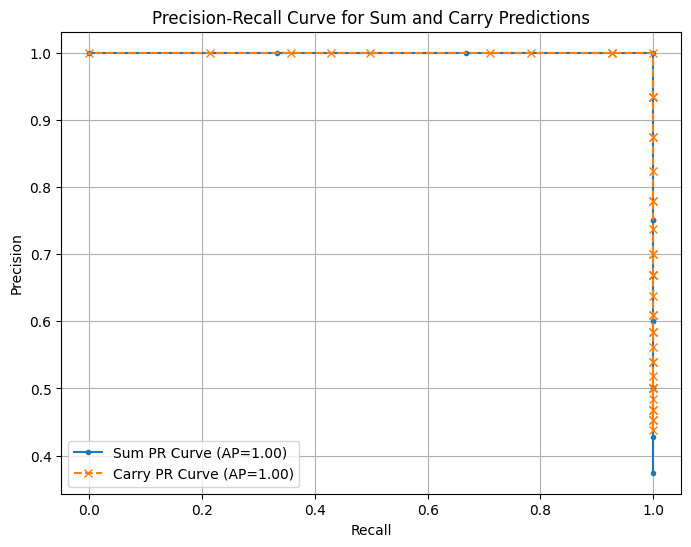

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize lists to store outputs and targets
all_targets = []
all_predictions = []

# Loop through the dataloader
for data in dataloader:
    inputs, targets = data
    inputs = inputs.to(device)  # Move to GPU if needed
    targets = targets.to(device)

    # Forward pass
    outputs = model(inputs)  # Logits output (before sigmoid)
    probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities

    # Collect data
    all_targets.append(targets.cpu().numpy())  # Move to CPU and convert to numpy
    all_predictions.append(probabilities.cpu().detach().numpy())  # Detach from graph

# Convert collected results into numpy arrays
all_targets = np.concatenate(all_targets, axis=0)  # Shape: (num_samples, 2)
all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (num_samples, 2)

# Ensure the arrays have correct shapes
assert all_targets.shape == all_predictions.shape, "Shape mismatch between predictions and targets"

# Compute Precision-Recall Curves for sum and carry separately
precision_sum, recall_sum, _ = precision_recall_curve(all_targets[:, 0].ravel(), all_predictions[:, 0].ravel())
precision_carry, recall_carry, _ = precision_recall_curve(all_targets[:, 1].ravel(), all_predictions[:, 1].ravel())

# Compute Average Precision Score (optional)
ap_sum = average_precision_score(all_targets[:, 0].ravel(), all_predictions[:, 0].ravel())
ap_carry = average_precision_score(all_targets[:, 1].ravel(), all_predictions[:, 1].ravel())

# Plot Precision-Recall Curves
plt.figure(figsize=(8, 6))
plt.plot(recall_sum, precision_sum, label=f'Sum PR Curve (AP={ap_sum:.2f})', linestyle='-', marker='.')
plt.plot(recall_carry, precision_carry, label=f'Carry PR Curve (AP={ap_carry:.2f})', linestyle='--', marker='x')

# Formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Sum and Carry Predictions")
plt.legend()
plt.grid()
plt.show()


## Evaluation

In [16]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

def evaluate_binary_addition(model, dataloader, sequence, device):
    accuracy = 0 
    bit_correct = 0
    digit_accuracy = 0
    sum_accuracy = 0
    carry_accuracy = 0
    final_batch_mean = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        sigmoid_output = torch.sigmoid(outputs)
        predictions = (sigmoid_output > 0.5).int()
        
        accuracy += (predictions == targets).float().mean().item()
        digit_accuracy += (predictions[:,:,1] == targets[:,:,1]).float().mean().item()
        carry_accuracy += (predictions[:,:,0] == targets[:,:,0]).float().mean().item()
        
        correct_tensor = (predictions == targets).float()
        bit_correct += correct_tensor.sum(dim=0, keepdim=True)
        
        batch_size, vector_length, _ = predictions.shape

        predictions_selected = targets[:,:,1] - predictions[:, :, 1]
        power_column_vectors = torch.pow(2, torch.arange(vector_length, device=device).float()).unsqueeze(0).unsqueeze(-1).expand(batch_size, -1, -1)
        result = predictions_selected.unsqueeze(-1) * power_column_vectors
        batch_wise_sum = result.sum(dim=1)
        final_batch_mean = final_batch_mean + batch_wise_sum.mean(dim=0)
    
    accuracy /= len(dataloader)
    digit_accuracy /= len(dataloader)
    carry_accuracy /= len(dataloader)
    sum_accuracy = final_batch_mean / len(dataloader)
    
    total_samples = len(dataloader.dataset)
    bit_accuracy = bit_correct / total_samples
    
    print(f"Sum Avg Error: {sum_accuracy.item():.4f}")
    print(f"Digit Accuracy: {digit_accuracy:.4f}")
    print(f"Carry Accuracy: {carry_accuracy:.4f}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Total Samples: {total_samples}")
    
    # Extract accuracy data
    digit_acc = bit_accuracy[0,:,1].to('cpu').numpy()
    carry_acc = bit_accuracy[0,:,0].to('cpu').numpy()
    
    positions = np.arange(1, sequence + 1)
    
    # Modern color scheme
    digit_color = '#4A90E2'
    carry_color = '#E94B3C'
    
    # Set modern style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with proper spacing - increased top margin
    fig = plt.figure(figsize=(18, 10), facecolor='white')
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.28, 
                          top=0.88, bottom=0.08, left=0.08, right=0.96)
    
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Main combined plot
    width = 0.35
    x = positions
    
    bars1 = ax1.bar(x - width/2, digit_acc * 100, width, label='Digit Accuracy',
                    color=digit_color, edgecolor='none', alpha=0.85)
    bars2 = ax1.bar(x + width/2, carry_acc * 100, width, label='Carry Accuracy',
                    color=carry_color, edgecolor='none', alpha=0.85)
    
    ax1.set_xlabel('Bit Position', fontsize=14, color='#333333')
    ax1.set_ylabel('Accuracy (%)', fontsize=14, color='#333333')
    ax1.set_ylim([0, 108])
    ax1.set_xticks(positions)
    ax1.tick_params(labelsize=11, colors='#666666')
    
    # Legend positioned in upper right, inside the plot
    ax1.legend(fontsize=12, loc='upper right', frameon=True, fancybox=False, 
               edgecolor='#CCCCCC', framealpha=1, bbox_to_anchor=(0.98, 0.98))
    
    ax1.grid(True, axis='y', alpha=0.2, linestyle='-', linewidth=0.8, color='#DDDDDD')
    ax1.set_axisbelow(True)
    
    # Remove spines
    for spine in ['top', 'right']:
        ax1.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax1.spines[spine].set_color('#CCCCCC')
        ax1.spines[spine].set_linewidth(1)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                    f'{height:.1f}', ha='center', va='bottom', 
                    fontsize=9, color='#555555')
    
    # Digit accuracy subplot
    bars_digit = ax2.bar(positions, digit_acc * 100, width=0.7, 
                         color=digit_color, edgecolor='none', alpha=0.85)
    ax2.set_xlabel('Bit Position', fontsize=13, color='#333333')
    ax2.set_ylabel('Accuracy (%)', fontsize=13, color='#333333')
    ax2.set_title('Digit Accuracy', fontsize=14, color='#333333', pad=10)
    ax2.set_ylim([0, 108])
    ax2.set_xticks(positions)
    ax2.tick_params(labelsize=11, colors='#666666')
    ax2.grid(True, axis='y', alpha=0.2, linestyle='-', linewidth=0.8, color='#DDDDDD')
    ax2.set_axisbelow(True)
    
    for spine in ['top', 'right']:
        ax2.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax2.spines[spine].set_color('#CCCCCC')
        ax2.spines[spine].set_linewidth(1)
    
    for bar in bars_digit:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                f'{height:.1f}', ha='center', va='bottom', 
                fontsize=9, color='#555555')
    
    # Carry accuracy subplot
    bars_carry = ax3.bar(positions, carry_acc * 100, width=0.7,
                        color=carry_color, edgecolor='none', alpha=0.85)
    ax3.set_xlabel('Bit Position', fontsize=13, color='#333333')
    ax3.set_ylabel('Accuracy (%)', fontsize=13, color='#333333')
    ax3.set_title('Carry Accuracy', fontsize=14, color='#333333', pad=10)
    ax3.set_ylim([0, 108])
    ax3.set_xticks(positions)
    ax3.tick_params(labelsize=11, colors='#666666')
    ax3.grid(True, axis='y', alpha=0.2, linestyle='-', linewidth=0.8, color='#DDDDDD')
    ax3.set_axisbelow(True)
    
    for spine in ['top', 'right']:
        ax3.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax3.spines[spine].set_color('#CCCCCC')
        ax3.spines[spine].set_linewidth(1)
    
    for bar in bars_carry:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                f'{height:.1f}', ha='center', va='bottom', 
                fontsize=9, color='#555555')
    
    # Main title and subtitle - properly positioned
    fig.suptitle('Binary Addition Model Evaluation', 
                fontsize=18, color='#222222', y=0.96, fontweight='600')
    
    # Summary info as subtitle
    summary_text = f'Overall: {accuracy*100:.1f}%  |  Samples: {total_samples:,}  |  Digit: {digit_accuracy*100:.1f}%  |  Carry: {carry_accuracy*100:.1f}%'
    fig.text(0.5, 0.90, summary_text, ha='center', fontsize=11, color='#666666')
    
    plt.show()
    
    return accuracy, sum_accuracy, carry_accuracy, bit_accuracy

## Test : 10 digit

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


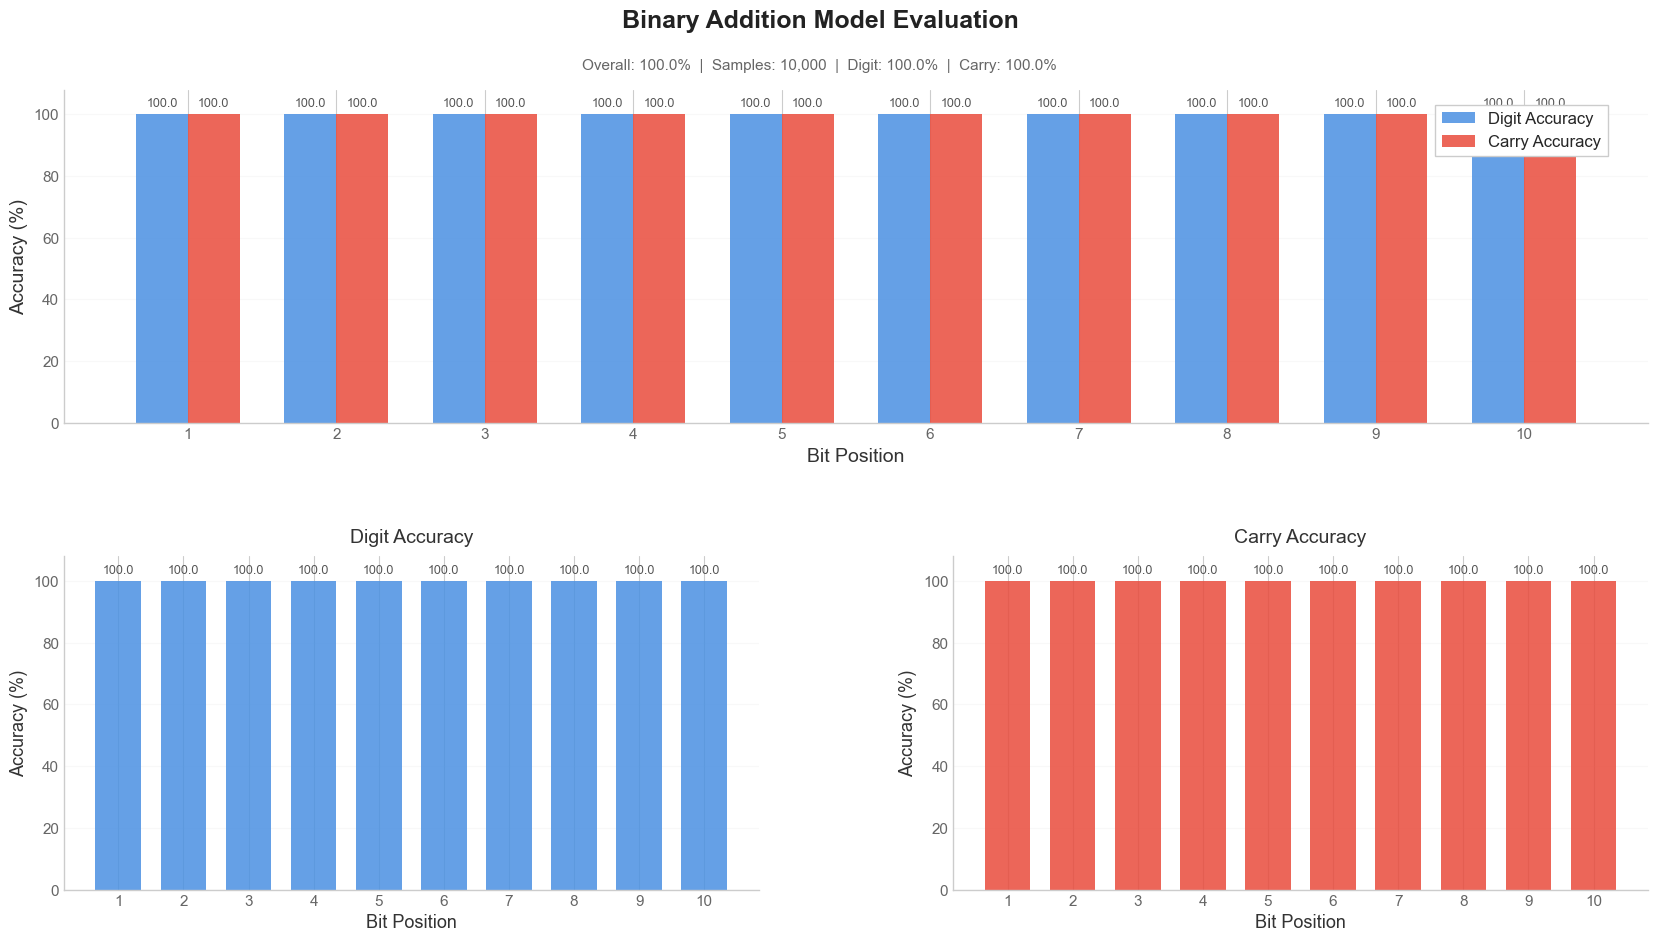

In [17]:
test_dataset = BinaryAdditionDataset(sequence=10, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
accuracy, sum_accuracy, carry_accuracy, bit_accuracy = evaluate_binary_addition(model,test_dataloader, sequence=10, device=device)

## Test : 5 digit

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


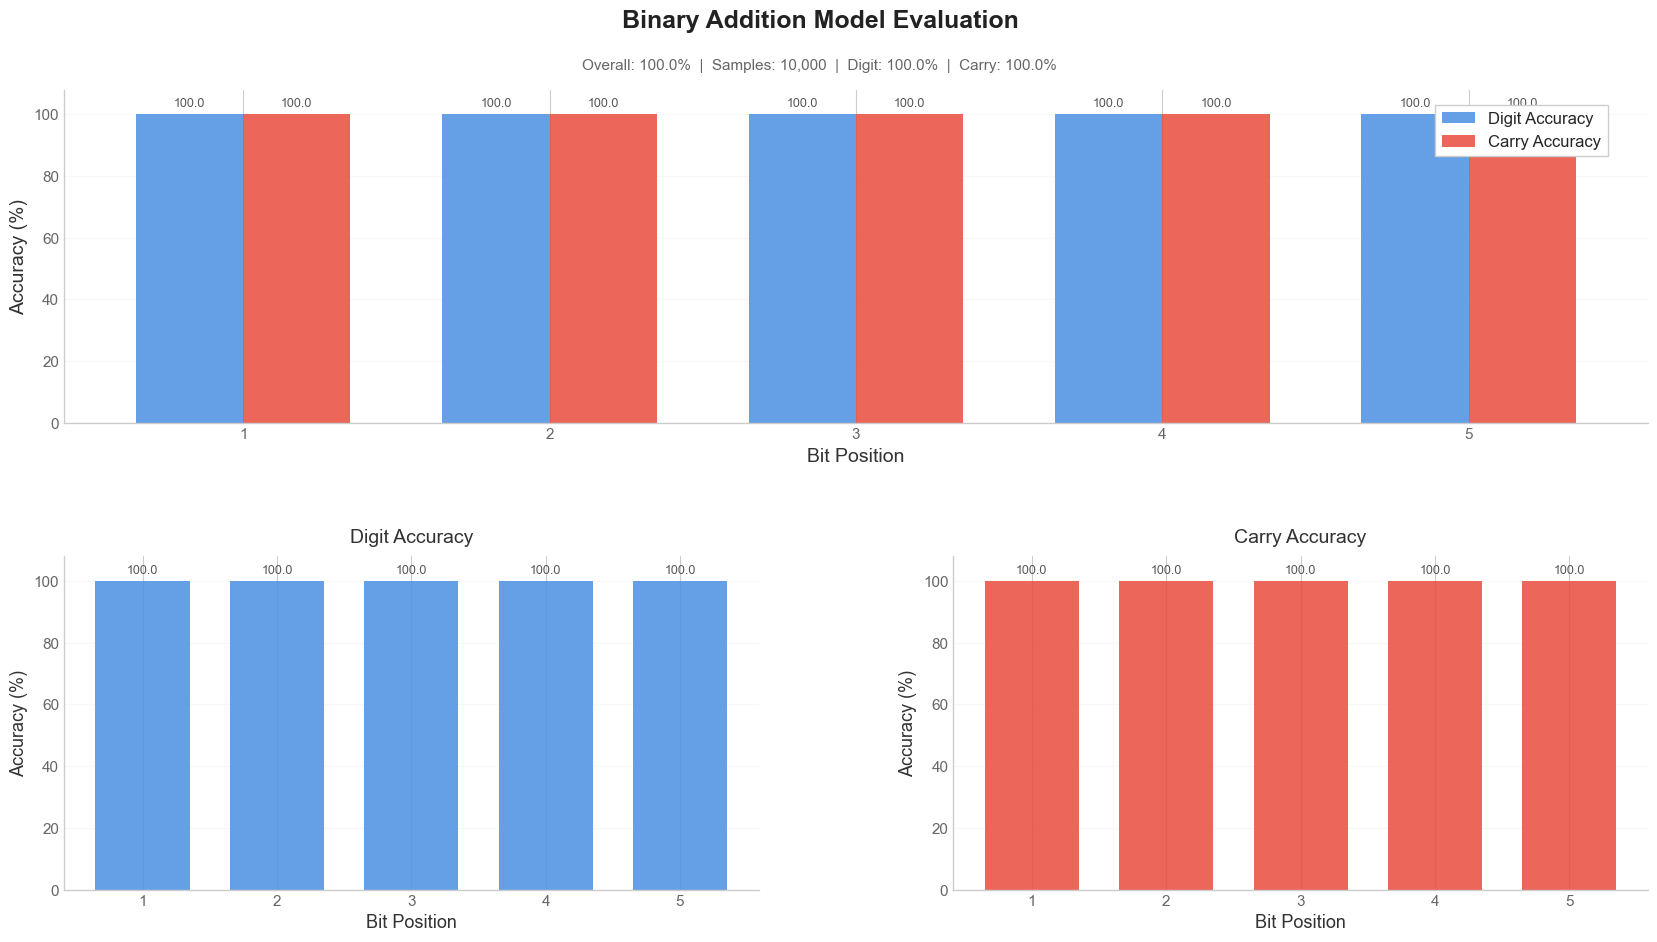

In [18]:
test_dataset = BinaryAdditionDataset(sequence=5, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

accuracy, sum_accuracy, carry_accuracy, bit_accuracy= evaluate_binary_addition(model,test_dataloader, sequence=5, device=device)


## Test : 13 digit

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


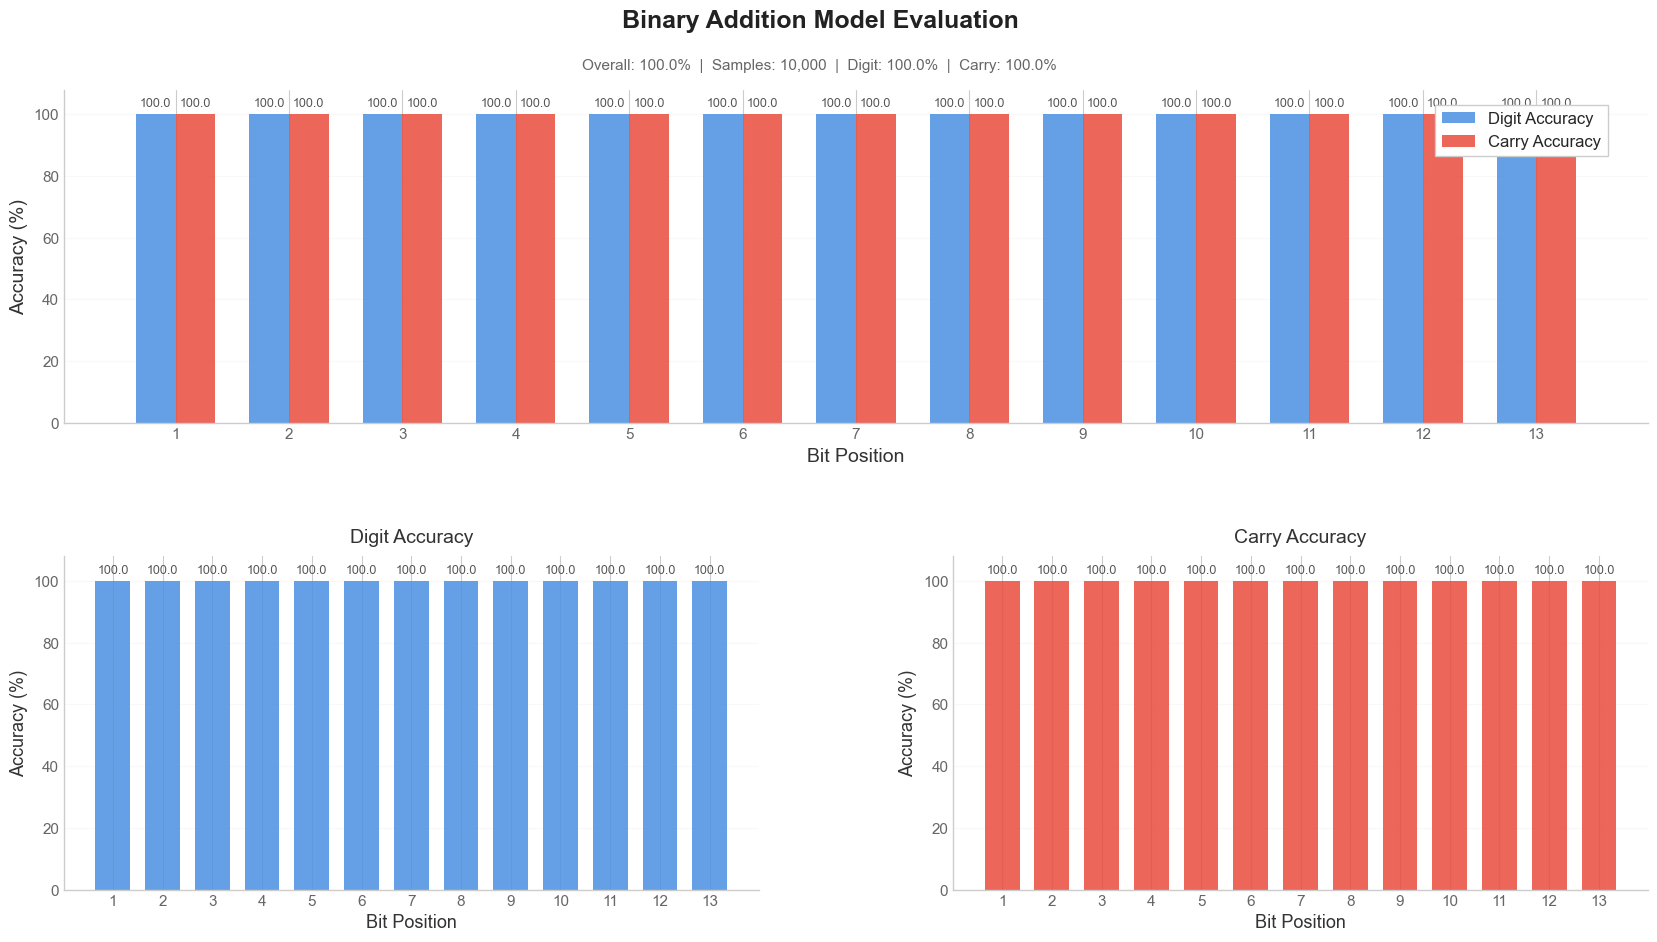

In [19]:
test_dataset = BinaryAdditionDataset(sequence=13, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
# evaluate_model(model, test_dataloader, device,sequence=13)
accuracy, sum_accuracy, carry_accuracy, bit_accuracy = evaluate_binary_addition(model,test_dataloader, sequence=13, device=device)


## 20 digits

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


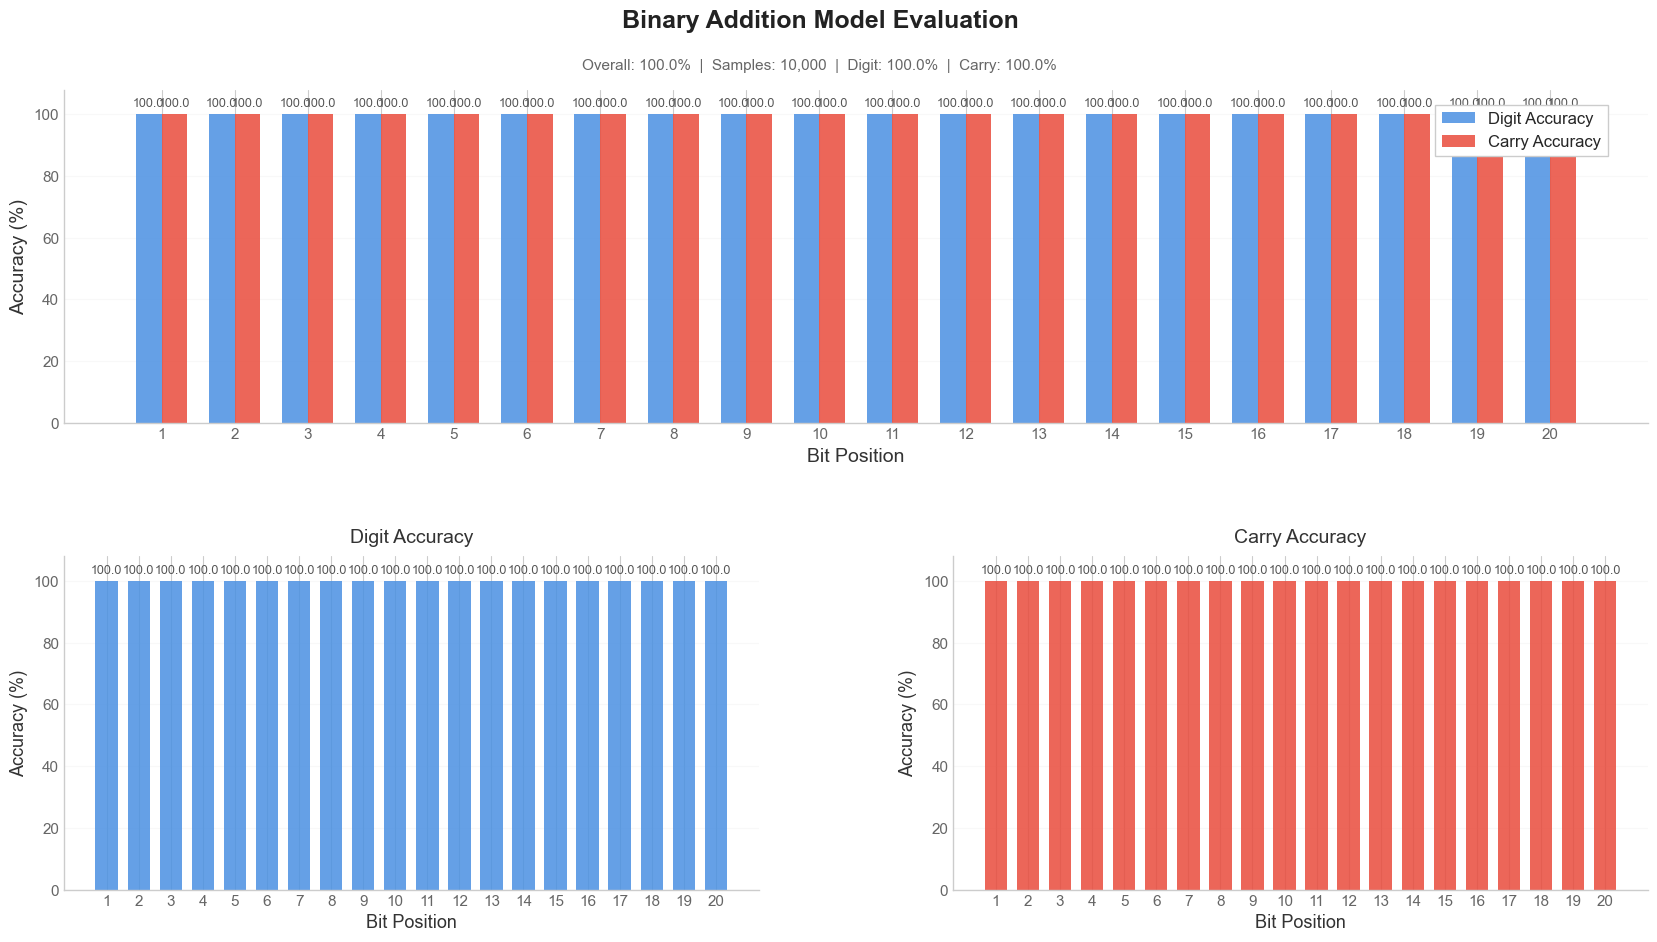

In [20]:
test_dataset = BinaryAdditionDataset(sequence=20, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
accuracy, sum_accuracy, carry_accuracy, bit_accuracy = evaluate_binary_addition(model,test_dataloader, sequence=20, device=device)


### 30 Digit

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


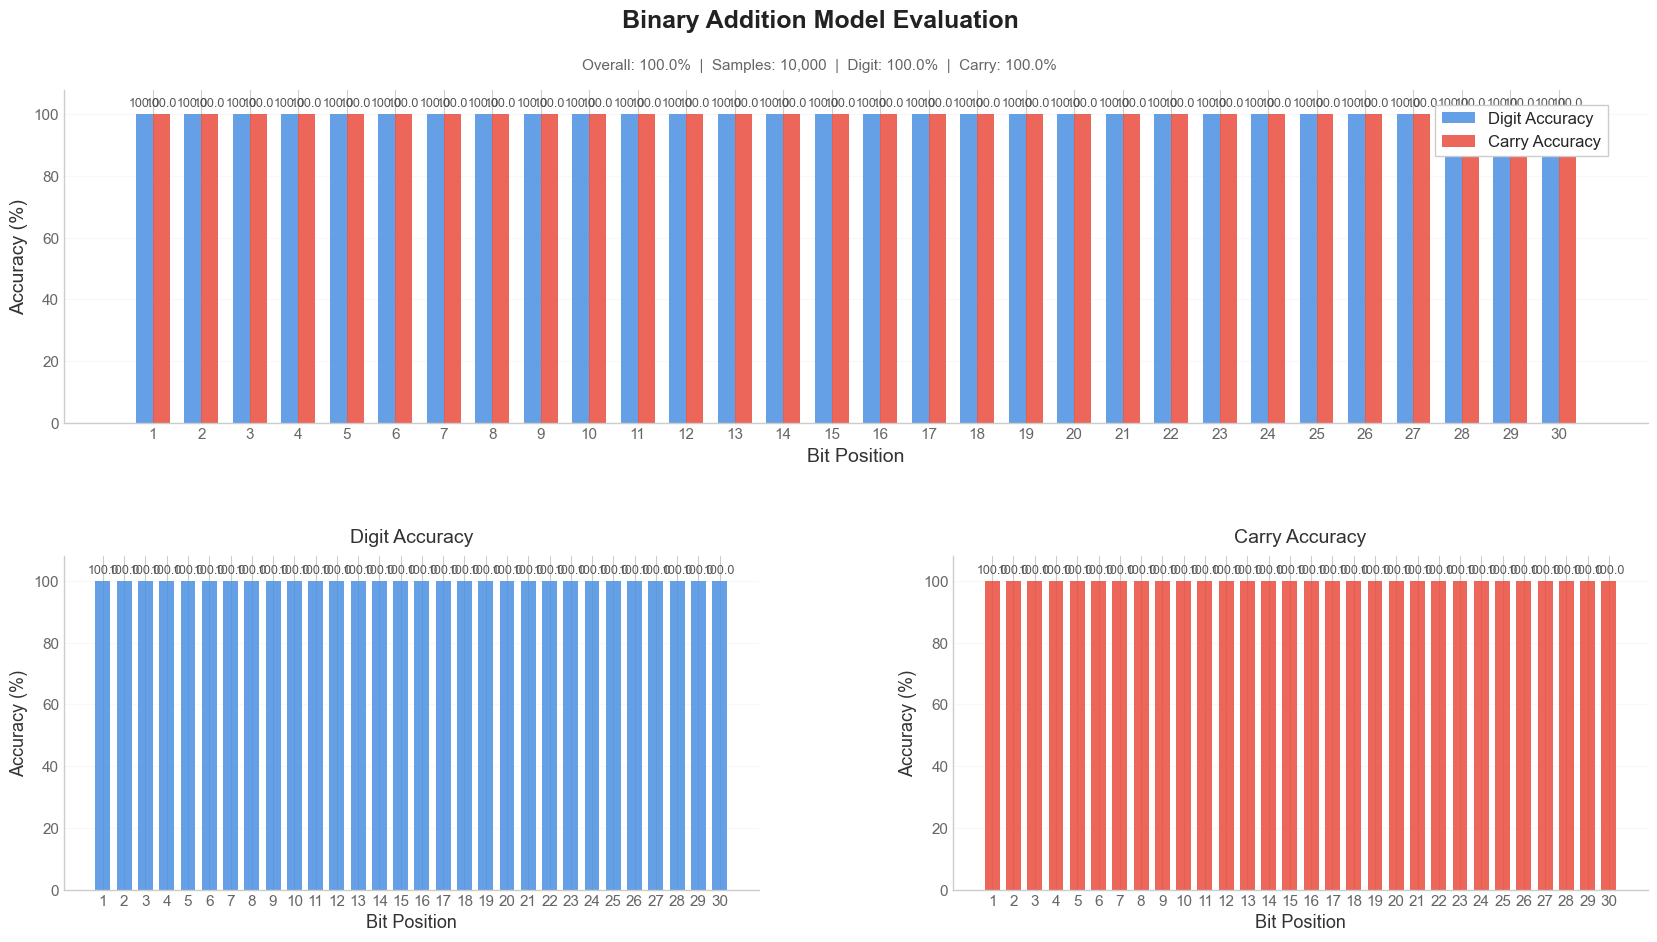

In [21]:
test_dataset = BinaryAdditionDataset(sequence=30, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
accuracy, sum_accuracy, carry_accuracy, bit_accuracy = evaluate_binary_addition(model,test_dataloader, sequence=30, device=device)

## 60 digits

Sum Avg Error: 0.0000
Digit Accuracy: 1.0000
Carry Accuracy: 1.0000
Overall Accuracy: 1.0000
Total Samples: 10000


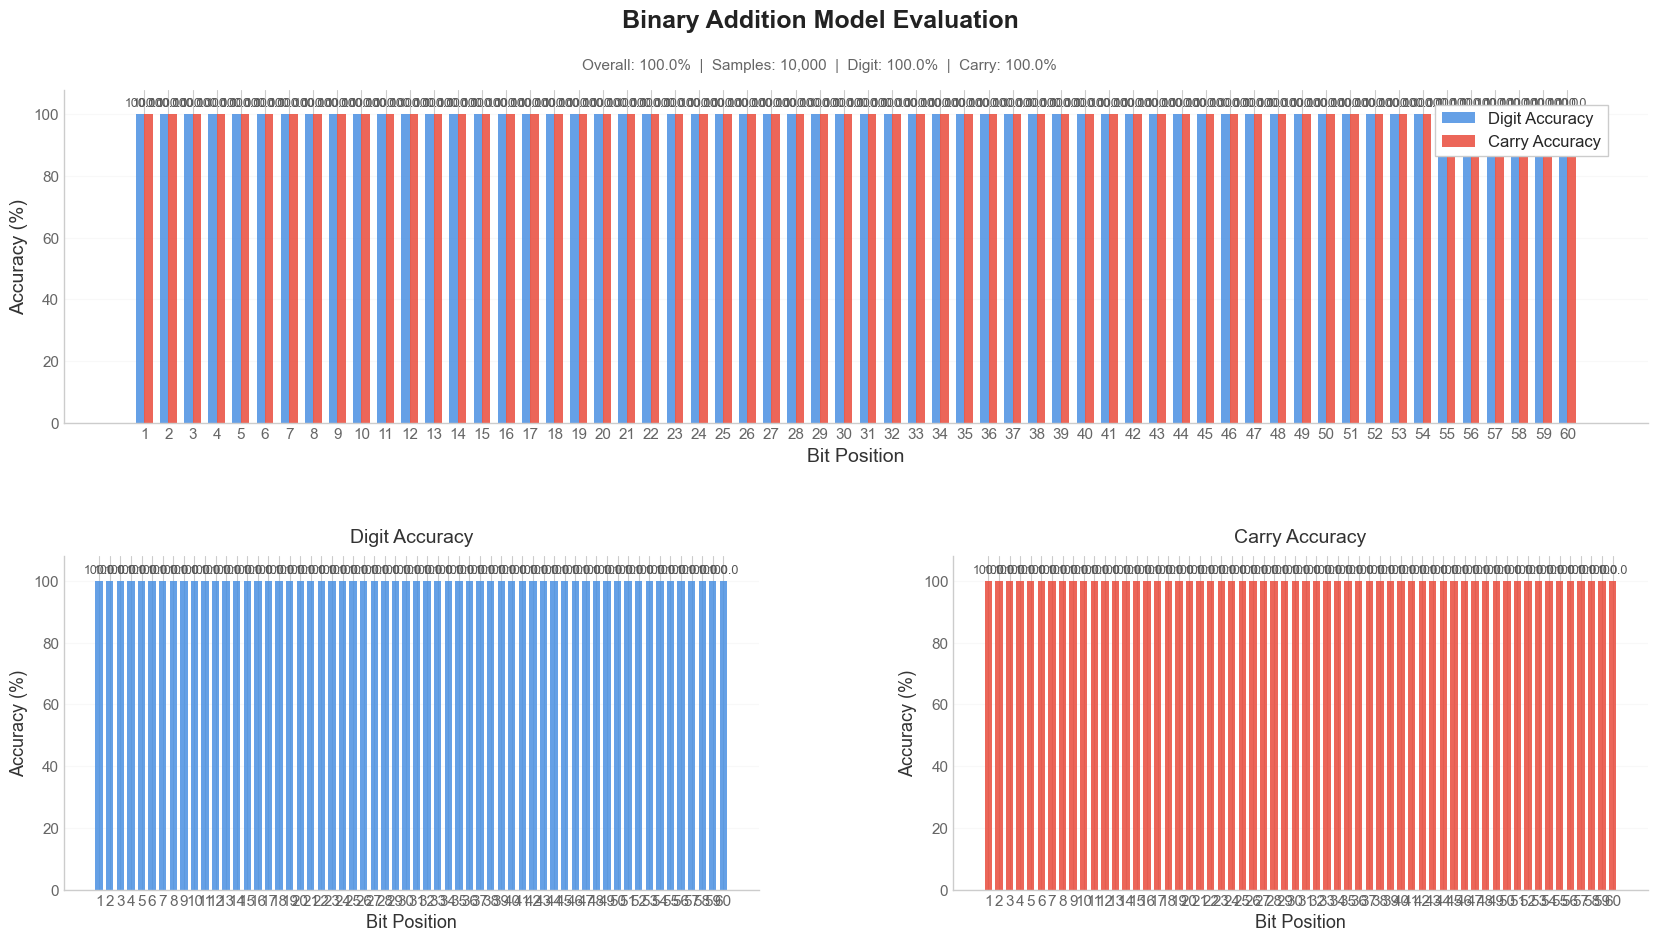

In [22]:
test_dataset = BinaryAdditionDataset(sequence=60, num_samples=10000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
accuracy, sum_accuracy, carry_accuracy, bit_accuracy = evaluate_binary_addition(model,test_dataloader, sequence=60, device=device)